<a href="https://colab.research.google.com/github/saptarshidatta96/MTech_Sem3/blob/main/CV_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow
import math
import sys, time

#Question 1: Sampling and Quantization

In [ ]:
barbara = imread('/content/barbara.jpg')
print(barbara)

[[ 87  92  97 ... 107 115 116]
 [109 112 121 ... 123 128 130]
 [162 161 172 ... 136 134 142]
 ...
 [ 82  88  89 ... 111 112 104]
 [ 84  85  84 ... 112 114 106]
 [ 83  80  83 ... 111 112 104]]


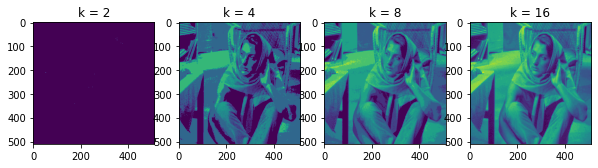

In [ ]:
k = 2**np.arange(1, 5)
figure, axis = plt.subplots(1, len(k), figsize=(10, 6))
for k, ax in zip(k, axis):
    bins = np.linspace(0, barbara.max(), k)
    image = (np.vectorize(bins.tolist().__getitem__)(np.digitize(barbara, bins)-1))
    ax.imshow(image)
    ax.set_title('k = {}'.format(k))

k = 2


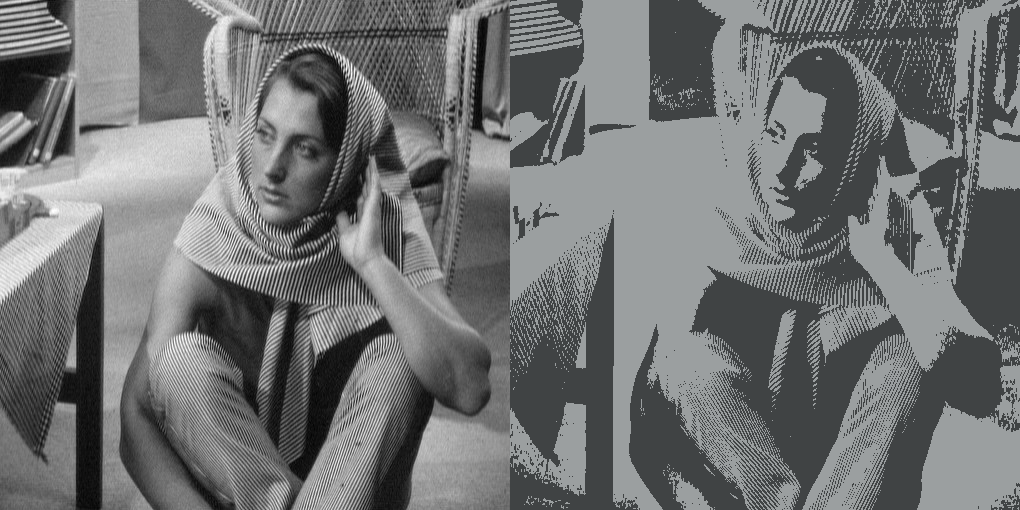

k = 8


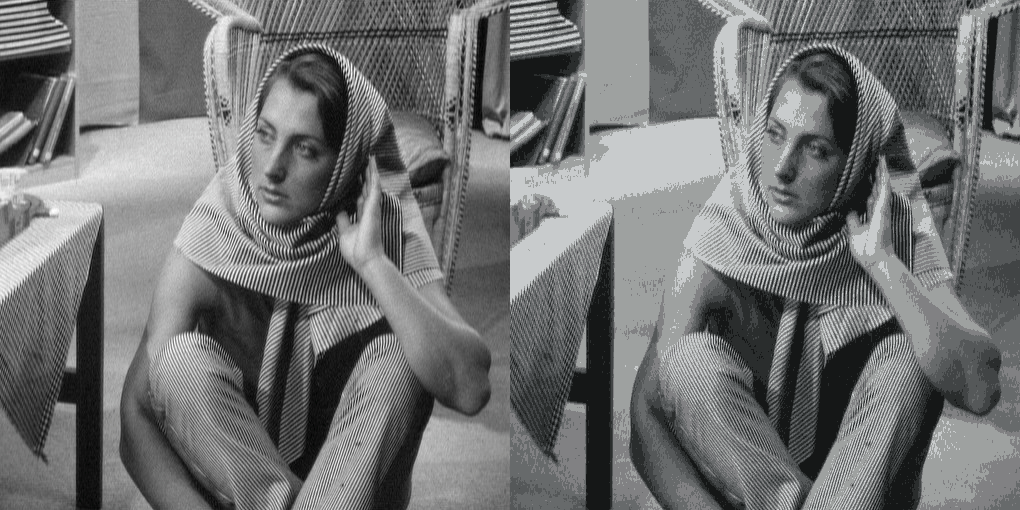

k = 16


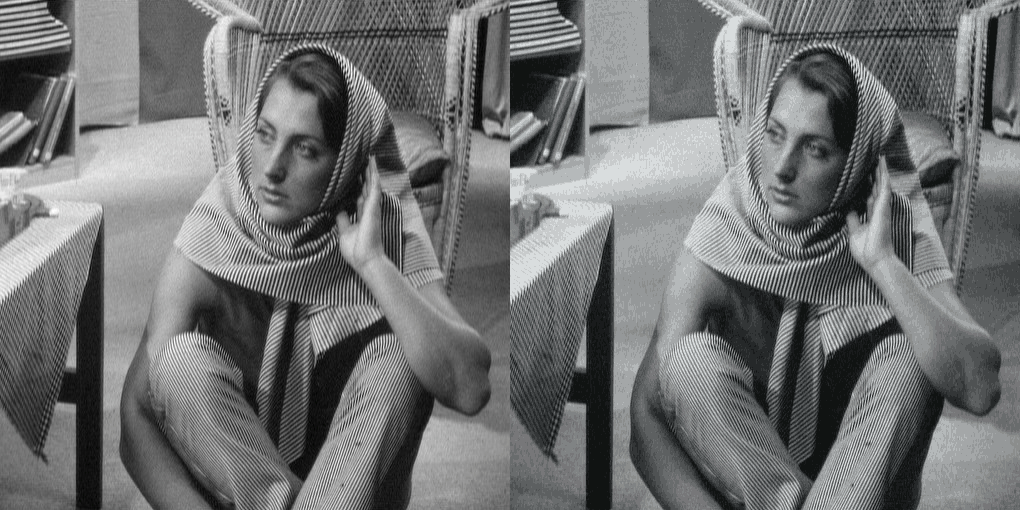

k = 32


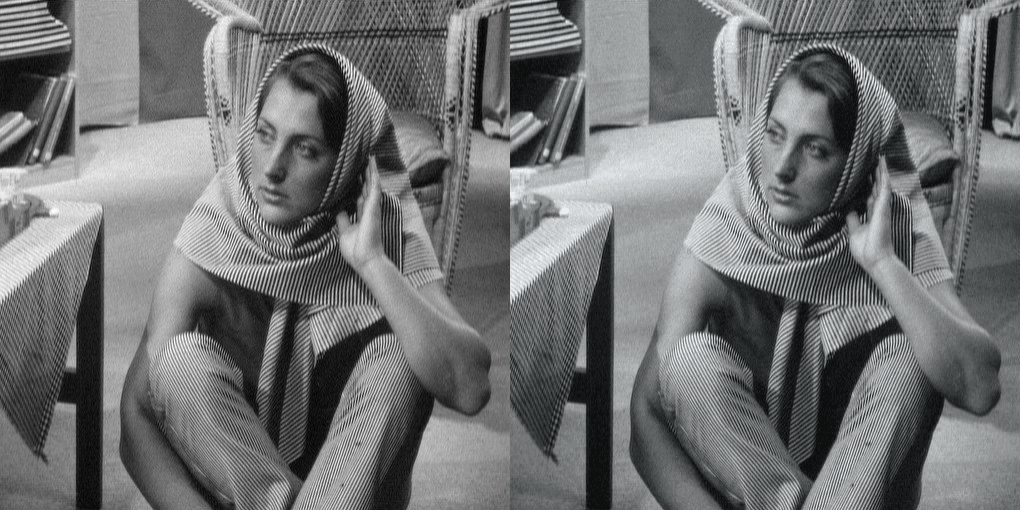

k = 40


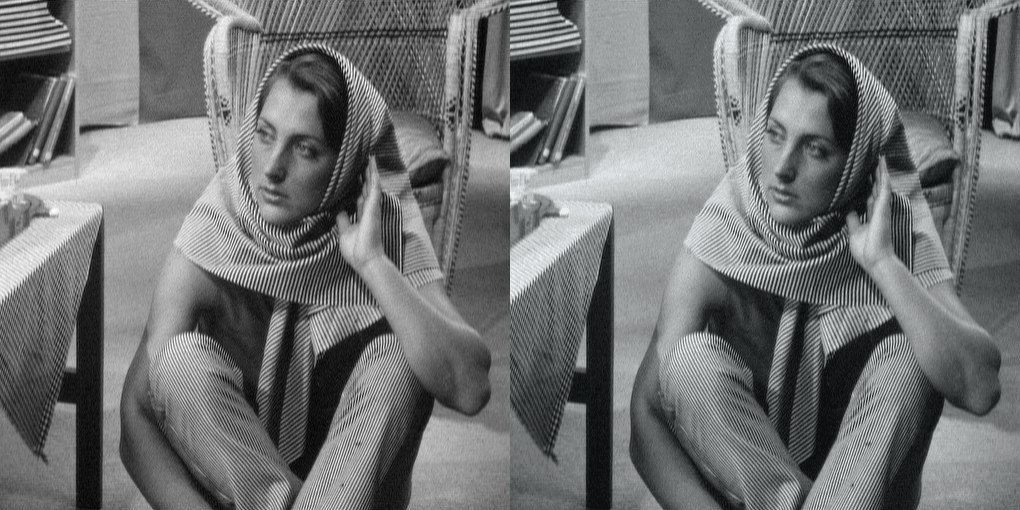

In [ ]:
image = cv2.imread('/content/barbara.jpg')
(h, w) = image.shape[:2]
k = [2,8,16,32,40]
for k in k:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = MiniBatchKMeans(n_clusters = k)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]
    quant = quant.reshape((h, w, 3))
    image = image.reshape((h, w, 3))
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    print('k = {}'.format(k))
    cv2_imshow(np.hstack([image, quant]))

#Question 2: Image interpolation

In [ ]:
def padding(img):
  H, W, C = img.shape
  padded_img = np.zeros((H+4, W+4, C))
  padded_img[2:H+2, 2:W+2, :C] = img
      
  # Pad the first/last two col and row
  padded_img[2:H+2, 0:2, :C] = img[:, 0:1, :C]
  padded_img[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
  padded_img[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
  padded_img[0:2, 2:W+2, :C] = img[0:1, :, :C]

  # Pad the missing eight points
  padded_img[0:2, 0:2, :C] = img[0, 0, :C]
  padded_img[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
  padded_img[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
  padded_img[0:2, W+2:W+4, :C] = img[0, W-1, :C]

  return padded_img


##Linear Interpolation

In [ ]:
def linear_kernel(a, b, c, d, x_d, y_d):
  out_pixel = a * (1-x_d) * (1-y_d) + b * (x_d) * (1-y_d) + c * (1-x_d) * (y_d) + d * x_d * y_d
  return out_pixel


In [ ]:
img = cv2.imread('/content/barbara.jpg')
dimension = img.shape
padded_img = padding(img)
padded_img.shape

(514, 514, 3)

In [ ]:
def linear_interpolation(img, scale):
    H, W, C = img.shape
    

    scale_x = (W)/(math.floor(W*scale))
    scale_y = (H)/(math.floor(H*scale))

    new_image = np.zeros((math.floor(H*scale), math.floor(W*scale), 3))

    for k in range(C):
        for i in range(math.floor(H*scale)):
            for j in range(math.floor(W*scale)):
                x = (j+0.5) * (scale_x) - 0.5
                y = (i+0.5) * (scale_y) - 0.5

                # Prevent crossing
                x_int = min(int(x), W-2)
                y_int = min(int(y), H-2)

                x_d = x - min(int(x), W-2)
                y_d = y - min(int(y), H-2)

                a = img[y_int, x_int, k]
                b = img[y_int, x_int+1, k]
                c = img[y_int+1, x_int, k]
                d = img[y_int+1, x_int+1, k]

                pixel = linear_kernel(a, b, c, d, x_d, y_d)

                new_image[i, j, k] = pixel.astype(np.uint8)

    return new_image

In [ ]:
linear_new_image = linear_interpolation(padded_img, 2)

In [ ]:
linear_new_image.shape

(1028, 1028, 3)

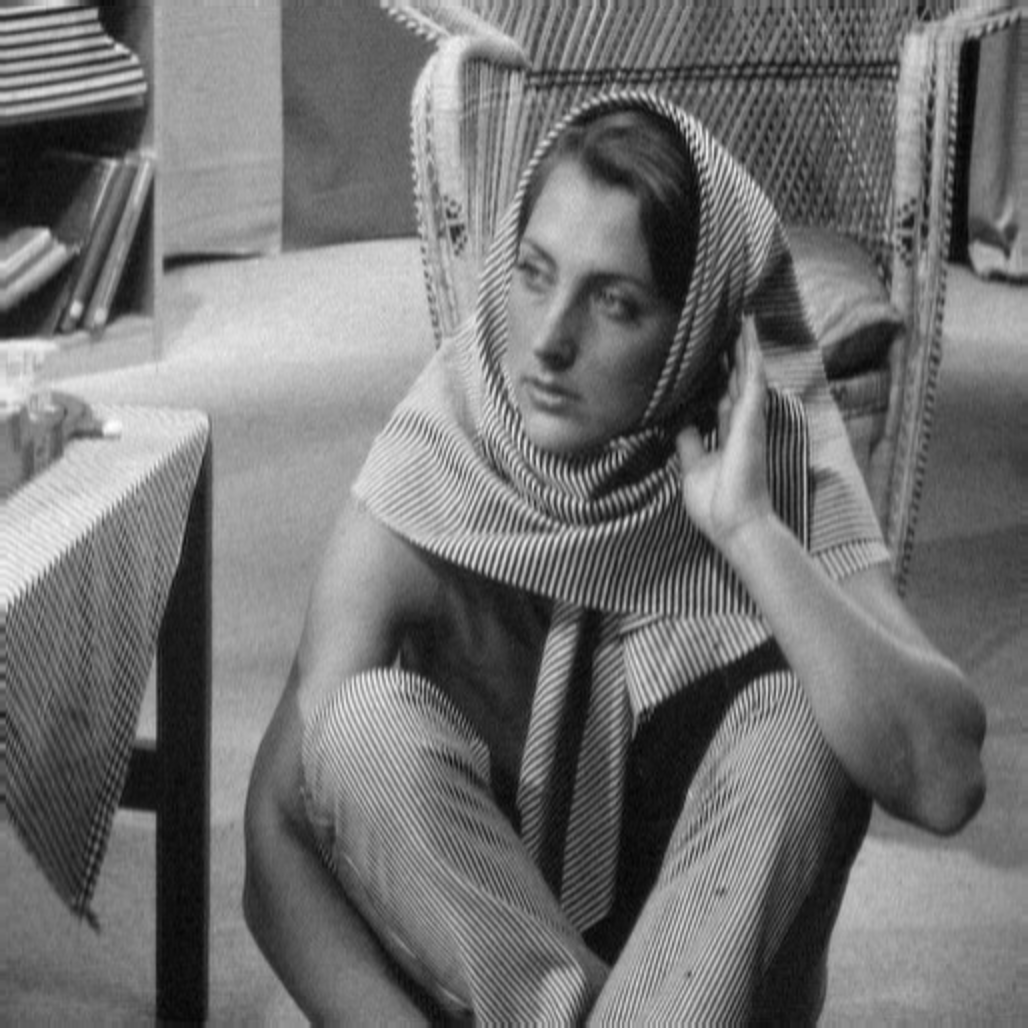

In [ ]:
cv2_imshow(linear_new_image)

back to original size

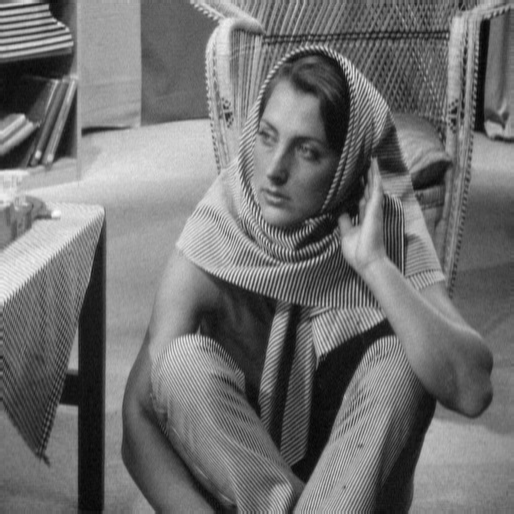

In [ ]:
linear_orig_image = linear_interpolation(linear_new_image, 0.5)
cv2_imshow(linear_orig_image)

##Bi-cubic Interpolation

In [ ]:
def u(x, a):
  if (abs(x) >= 0) & (abs(x) <= 1):
    return (a+2)*(abs(x)**3)-(a+3)*(abs(x)**2)+1
  elif (abs(x) > 1) & (abs(x) <= 2):
    return a*(abs(x)**3)-(5*a)*(abs(x)**2)+(8*a)*abs(x)-4*a
  else:
    return 0

In [ ]:
def bicubic_interpolation(img, scale):
  H, W, C = img.shape
  padded_img = padding(img)
  new_image = np.zeros((math.floor(H*scale), math.floor(W*scale), 3))


  for c in range(C):
        for j in range(math.floor(H*scale)):
            for i in range(math.floor(W*scale)):
                
                # Getting the coordinates of the
                # nearby values
                x, y = i * 0.5 + 2, j * 0.5 + 2
  
                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x
  
                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y
                  
                # Considering all nearby 16 values
                mat_l = np.matrix([[u(x1, -0.5), u(x2, -0.5), u(x3, -0.5), u(x4, -0.5)]])
                mat_m = np.matrix([[padded_img[int(y-y1), int(x-x1), c],
                                    padded_img[int(y-y2), int(x-x1), c],
                                    padded_img[int(y+y3), int(x-x1), c],
                                    padded_img[int(y+y4), int(x-x1), c]],
                                   [padded_img[int(y-y1), int(x-x2), c],
                                    padded_img[int(y-y2), int(x-x2), c],
                                    padded_img[int(y+y3), int(x-x2), c],
                                    padded_img[int(y+y4), int(x-x2), c]],
                                   [padded_img[int(y-y1), int(x+x3), c],
                                    padded_img[int(y-y2), int(x+x3), c],
                                    padded_img[int(y+y3), int(x+x3), c],
                                    padded_img[int(y+y4), int(x+x3), c]],
                                   [padded_img[int(y-y1), int(x+x4), c],
                                    padded_img[int(y-y2), int(x+x4), c],
                                    padded_img[int(y+y3), int(x+x4), c],
                                    padded_img[int(y+y4), int(x+x4), c]]])
                mat_r = np.matrix(
                    [[u(y1, -0.5)], [u(y2, -0.5)], [u(y3, -0.5)], [u(y4, -0.5)]])
                  
                # Here the dot function is used to get 
                # the dot product of 2 matrices
                new_image[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)

  return new_image

In [ ]:
img = cv2.imread('/content/barbara.jpg')
dimension = img.shape
bicubic_new_image = bicubic_interpolation(img, 2)

In [ ]:
bicubic_new_image.shape

(1020, 1020, 3)

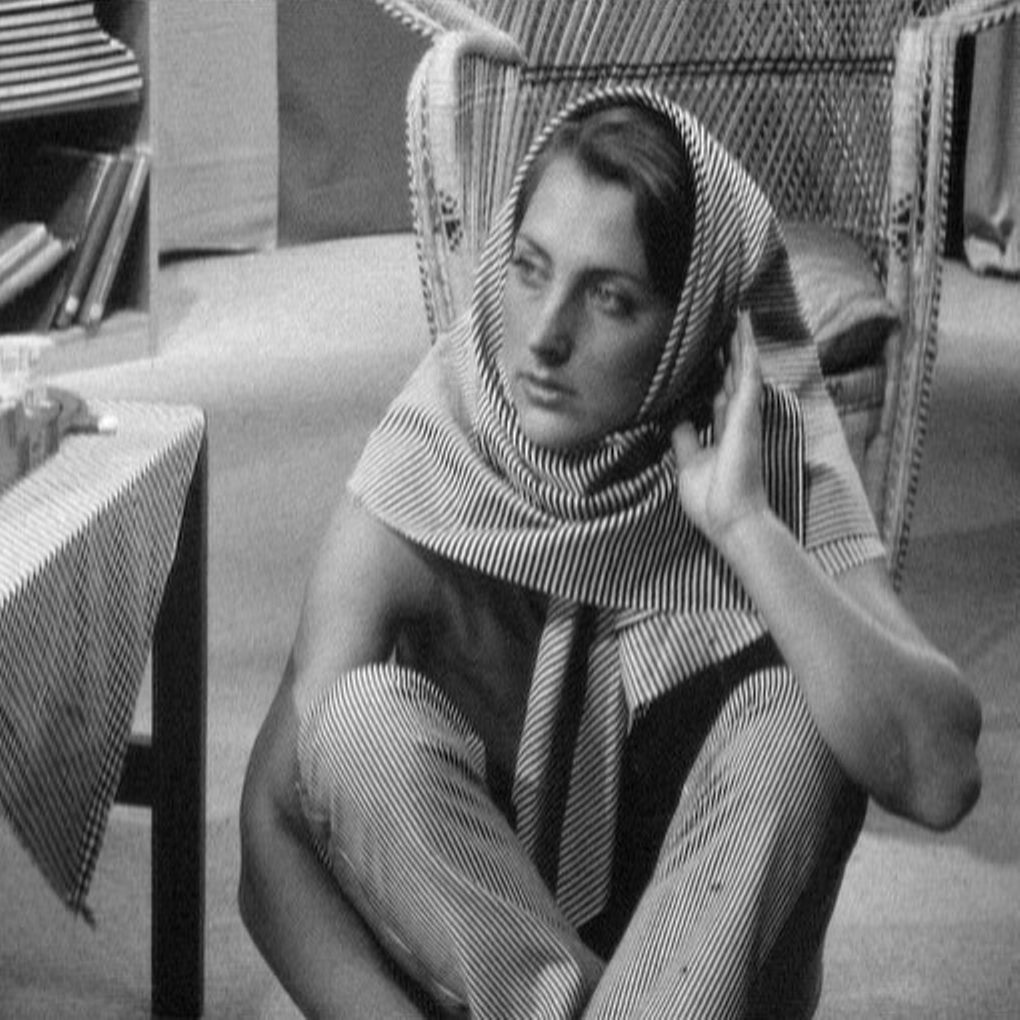

In [ ]:
cv2_imshow(bicubic_new_image)

back to original size

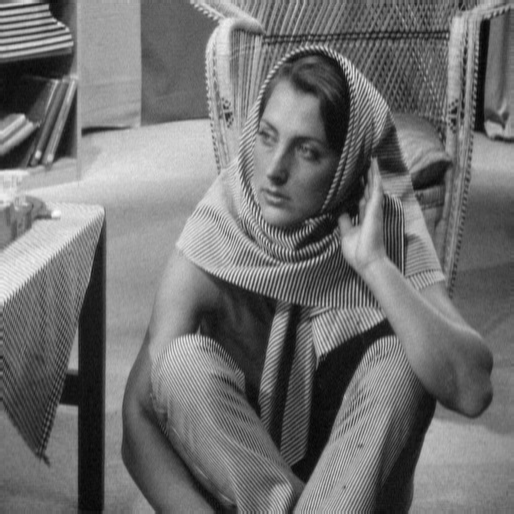

In [ ]:
bicubic_orig_image = linear_interpolation(linear_new_image, 0.5)
cv2_imshow(bicubic_orig_image)

#Question 3: Affine Transformation

##(a) Translation by 2 pixels in any direction.

In [ ]:
def translate_img(img,t_x, t_y):
  ts_mat = np.array([[1,0,t_x],[0,1,t_y],[0, 0, 1]])
  H, W, C = img.shape
  out_img = np.zeros((H, W, C))

  for k in range(C):
    for i in range(H):
      for j in range(W):
        xy = np.array([j, i, 1])

        new_xy = np.dot(ts_mat,xy)
        new_x = new_xy[0]
        new_y = new_xy[1]

        if 0<new_x < W and 0<new_y < H:
          out_img[new_y,new_x]  = img[i,j]

  return out_img    
img = cv2.imread('/content/barbara.jpg')

out_img = translate_img(img, 2, 2)

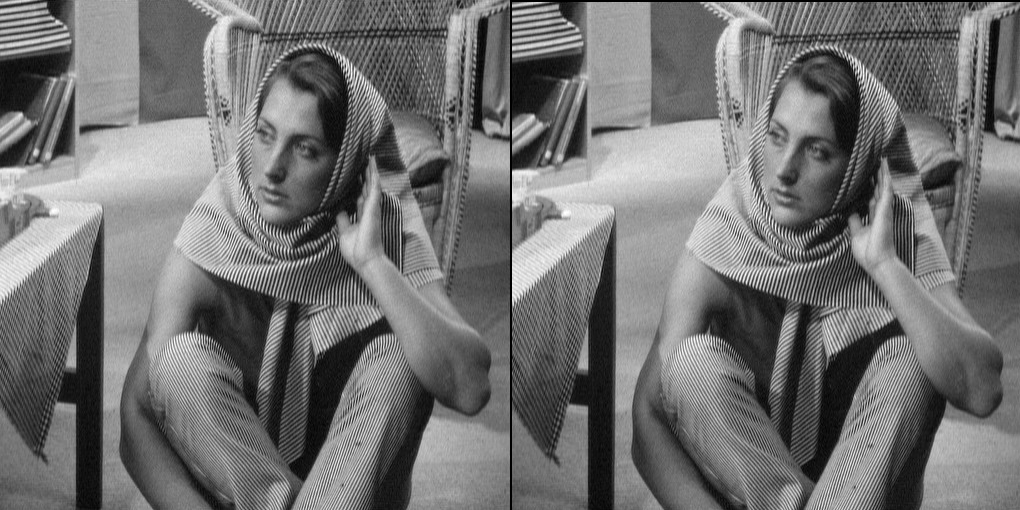

In [ ]:
cv2_imshow(np.hstack([img, out_img]))

##(b) Scaling by a factor of 2 in the x-direction.

In [ ]:
def translate_img(img,scale):

  shrunk_img = linear_interpolation(img, 0.5)
  ts_mat = np.array([[scale,0,0],[0,scale,0],[0, 0, 1]])
  H, W, C = img.shape
  out_img = np.zeros((H, W, C))

  for k in range(C):
    for i in range(H):
      for j in range(W):
        xy = np.array([j, i, 1])

        new_xy = np.dot(ts_mat,xy)
        new_x = new_xy[0]
        new_y = new_xy[1]

        if 0<new_x < W and 0<new_y < H:
          out_img[new_y,new_x]  = shrunk_img[i,j]

  return out_img    
img = cv2.imread('/content/barbara.jpg')

out_img = translate_img(img,2)

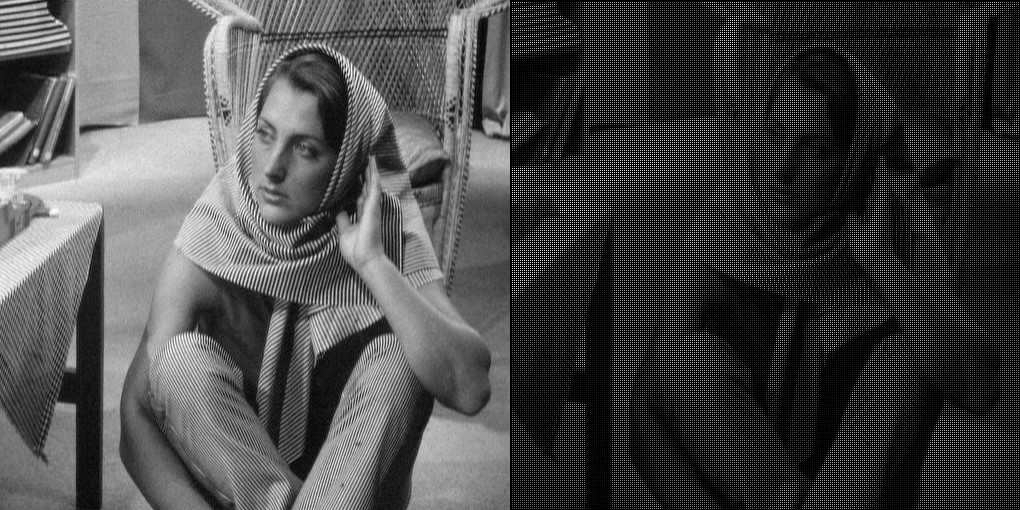

In [ ]:
cv2_imshow(np.hstack([img, out_img]))

##(c) Rotation by 30 degrees in the anti-clockwise direction.

In [ ]:
def rotate_img(img,angle,pivot_point):

    #1.create rotation matrix with numpy array
    rotation_mat = np.transpose(np.array([[np.cos(angle),-np.sin(angle)],
                            [np.sin(angle),np.cos(angle)]]))
    H, W = img.shape[:2]
    
    pivot_x =  pivot_point[0]
    pivot_y = pivot_point[1]
    
    new_img = np.zeros((H, W, 3))

    for i in range(H):
        for j in range(W): 
            xy_mat = np.array([[j-pivot_x],[i-pivot_y]])
            
            rotate_mat = np.dot(rotation_mat,xy_mat)

            new_x = pivot_x + int(rotate_mat[0])
            new_y = pivot_y + int(rotate_mat[1])


            if (0<=new_x<W) and (0<=new_y<H): 
                new_img[new_y,new_x] = img[i,j]

    return new_img

img = cv2.imread('/content/barbara.jpg')

out_img = rotate_img(img,30,(img.shape[0]//2, img.shape[1]//2))

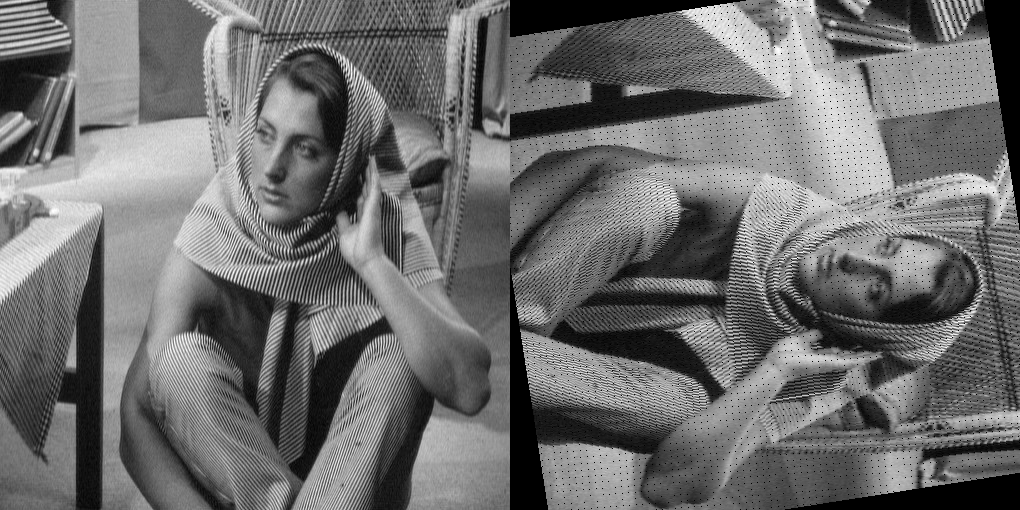

In [ ]:
cv2_imshow(np.hstack([img, out_img]))

##(d) A combination of the above three operations.

#Question 4: Gaussian and Laplacian Pyramid

In [ ]:
def convolve2d(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image)

    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    image_padded[1:-1, 1:-1] = image

    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x] = (kernel * image_padded[y: y+3, x: x+3]).sum()

    return output

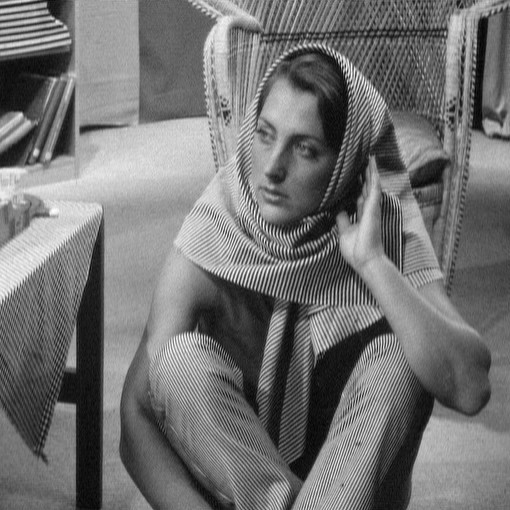

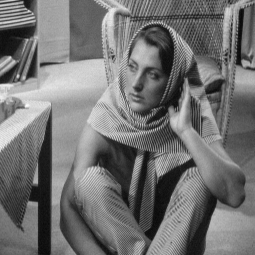

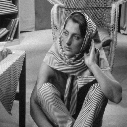

In [ ]:
img = cv2.imread("/content/barbara.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
layer = img.copy() 
kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16.0
rows, cols= map(int, layer.shape)

for i in range(3):
    # using pyrDown() function
    layer = convolve2d(img, kernel)
    layer = cv2.resize(img, (rows, cols))
    rows = rows //2
    cols = cols // 2
    cv2_imshow(layer)

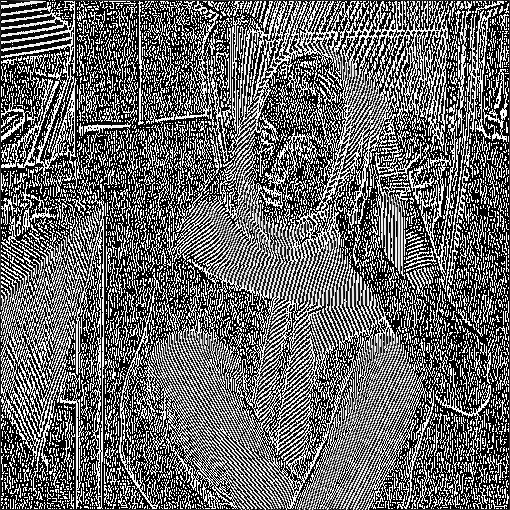

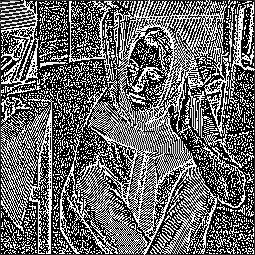

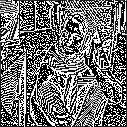

In [ ]:
img = cv2.imread("/content/barbara.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
layer = img.copy() 
kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16.0
rows, cols= map(int, layer.shape)

for i in range(3):
    layer = convolve2d(layer, kernel)
    layer = cv2.resize(img, (rows, cols))
    for i in range(1):
        down = convolve2d(layer, kernel)
        up = cv2.resize(down, (rows, cols))
        cv2_imshow(layer-up)
    rows = rows //2
    cols = cols//2


#Question 5: Histogram

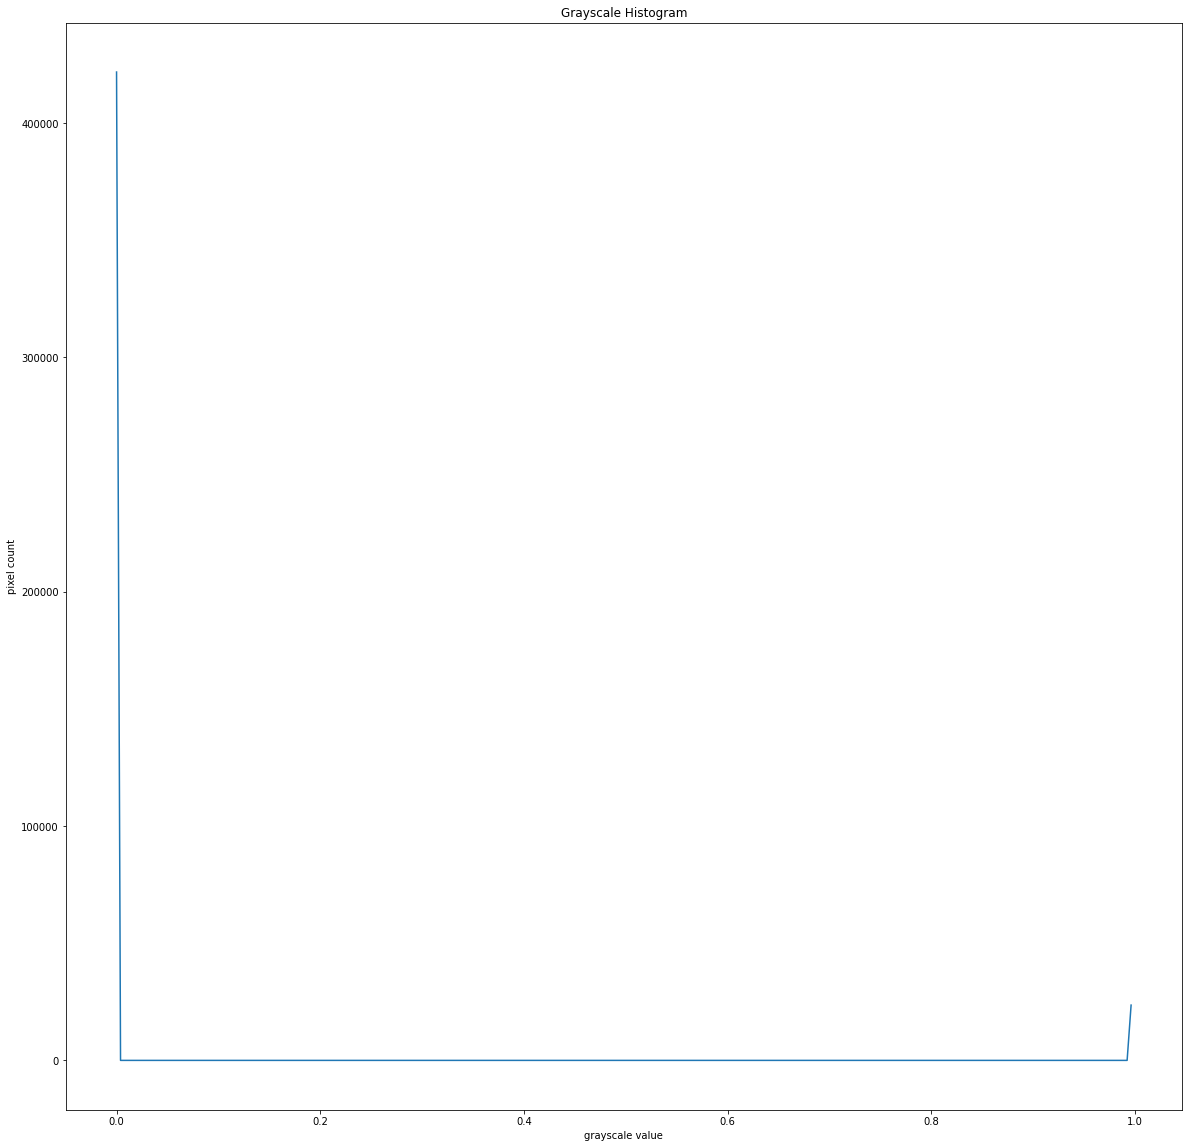

In [ ]:
moon = cv2.imread('/content/moon.tif')
moon = cv2.cvtColor(moon, cv2.COLOR_BGR2GRAY)
histogram, bin_edges = np.histogram(moon, bins=256, range=(0, 1))
plt.figure(figsize=(20, 20))
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

Contrast Stretching

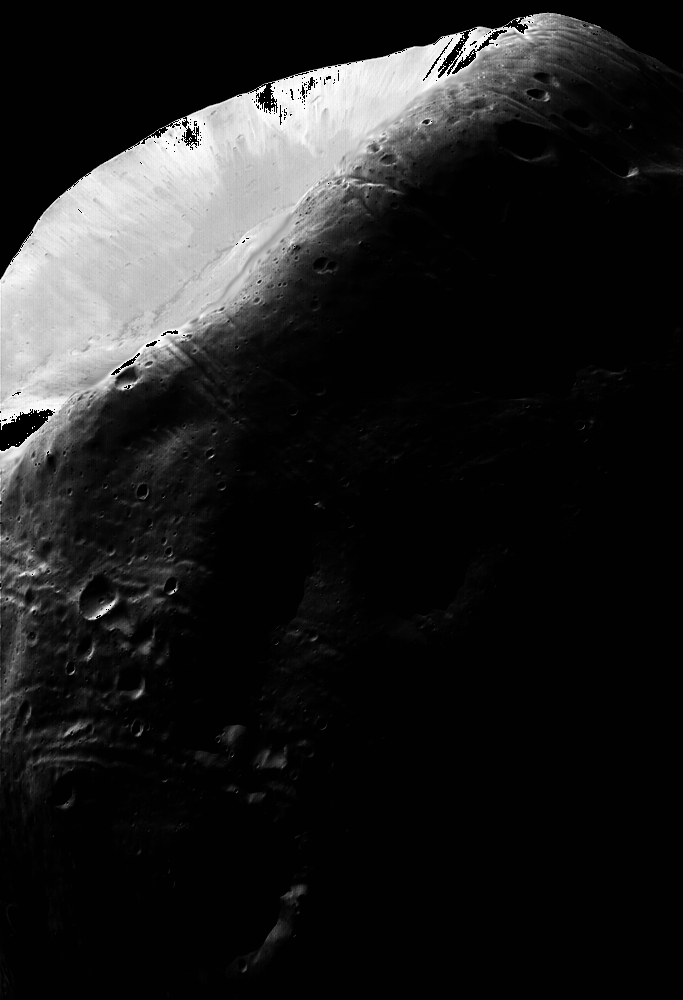

In [ ]:
moon = cv2.imread('/content/moon.tif')
moon = cv2.cvtColor(moon, cv2.COLOR_BGR2GRAY)
img = moon.copy()
H, W = moon.shape

for i in range(H):
  for j in range(W):
    moon[i, j] = moon[i, j]+255//255
cv2_imshow(moon)

In [ ]:
moon.max()

255